In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import copy
from collections import Counter

In [2]:
pubs_author_funder = pd.read_csv("..//..//..//data//Data//DerivedData//CleanedRawData//pubs_author_funder.csv")
pubs_author_funder['author_country'] = pubs_author_funder['author_country'].apply(literal_eval)
#pubs_author_funder['funder_country'] = pubs_author_funder['funder_country'].apply(literal_eval)

/home/miaoli/conda/envs/funding/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
pubs_author_funder['author_country_distinct']=pubs_author_funder[
    'author_country'].apply(lambda x: list(set(x)))

In [4]:
pubs_author_funder['IntCol'] = pubs_author_funder[
    'author_country_distinct'].apply(lambda x: 1 if len(x)>1 else 0)
pubs_author_funder.head()

,id,author_country,funder_country,author_country_distinct,IntCol
0,30507292,[Turkey],['Turkey'],[Turkey],0
1,30574690,"[United States, France]","['United States', 'United States', 'United Sta...","[United States, France]",1
2,30574691,[Russia],['Russia'],[Russia],0
3,30585095,"[Spain, Spain]","['Spain', 'Spain', 'Spain', 'Spain', 'Spain', ...",[Spain],0
4,30585097,"[Germany, Spain]",['Spain'],"[Germany, Spain]",1


In [5]:
pubs_author_funder['funder_country'] = pubs_author_funder[
    'funder_country'].apply(lambda x: literal_eval(x) if pd.notnull(x) else x)


In [6]:
authorcntry_df = pubs_author_funder.explode('author_country_distinct')
authorcntry_df.head()

,id,author_country,funder_country,author_country_distinct,IntCol
0,30507292,[Turkey],[Turkey],Turkey,0
1,30574690,"[United States, France]","[United States, United States, United States, ...",United States,1
1,30574690,"[United States, France]","[United States, United States, United States, ...",France,1
2,30574691,[Russia],[Russia],Russia,0
3,30585095,"[Spain, Spain]","[Spain, Spain, Spain, Spain, Spain, Spain]",Spain,0


In [8]:
cntrylist = authorcntry_df.author_country_distinct.unique()


In [9]:
def get_cntrycontribution(data, cntry):
    data_filter=data[data.funder_country.notnull()]
    fundingrecord = data_filter.funder_country.tolist()
    unitlist=[]
    for record in fundingrecord:
        unitlist.append(Counter(record)[cntry])
    return sum(unitlist)

In [10]:
resultlist=[]
for cntry in cntrylist:
    cntry_df=authorcntry_df[authorcntry_df.author_country_distinct==cntry]
    cntry_self=cntry_df[cntry_df.IntCol==0]
    num_self=cntry_self.shape[0]
    funding_self=get_cntrycontribution(cntry_self, cntry)
    cntry_col=cntry_df[cntry_df.IntCol==1]
    num_col=cntry_col.shape[0]
    funding_col=get_cntrycontribution(cntry_col, cntry)
    resultlist.append([cntry, num_self, funding_self, num_col, funding_col])

In [11]:
funding_col = pd.DataFrame(resultlist, columns=[
    'author_cntry','self','funding_self','col','funding_col'])
funding_col.head()

,author_cntry,self,funding_self,col,funding_col
0,Turkey,189249,56581,52402,20185
1,United States,1941880,3030042,1266929,1617499
2,France,276507,195529,386280,212195
3,Russia,205063,201816,109985,110536
4,Spain,229595,355974,252352,312844


In [12]:
funding_col['self_avg']=funding_col['funding_self']/funding_col['self']
funding_col['col_avg']=funding_col['funding_col']/funding_col['col']
funding_col = funding_col.fillna(0)

In [13]:
flag_table=pd.read_csv(
    "..//..//..//data//Data//AdditionalData//country_WoS_ECI_WB_flags.tsv", sep="\t")
flag_table.head()

,WoS,ECI_Country,WB,Code
0,Albania,Albania,Albania,ALB
1,Algeria,Algeria,Algeria,DZA
2,Angola,Angola,Angola,AGO
3,Argentina,Argentina,Argentina,ARG
4,Australia,Australia,Australia,AUS


In [14]:
funding_col.head()

,author_cntry,self,funding_self,col,funding_col,self_avg,col_avg
0,Turkey,189249,56581,52402,20185,0.298976,0.385195
1,United States,1941880,3030042,1266929,1617499,1.560365,1.276708
2,France,276507,195529,386280,212195,0.707139,0.549330
3,Russia,205063,201816,109985,110536,0.984166,1.005010
4,Spain,229595,355974,252352,312844,1.550443,1.239713


In [15]:
funding_col=funding_col.merge(
    flag_table[['WoS','Code']], right_on="WoS", left_on="author_cntry", how="left")
funding_col.head()

,author_cntry,self,funding_self,col,funding_col,self_avg,col_avg,WoS,Code
0,Turkey,189249,56581,52402,20185,0.298976,0.385195,Turkey,TUR
1,United States,1941880,3030042,1266929,1617499,1.560365,1.276708,United States,USA
2,France,276507,195529,386280,212195,0.707139,0.549330,France,FRA
3,Russia,205063,201816,109985,110536,0.984166,1.005010,Russia,RUS
4,Spain,229595,355974,252352,312844,1.550443,1.239713,Spain,ESP


In [16]:
topavg = funding_col.sort_values(by="self_avg", ascending=False).head(30)
label=topavg.Code.tolist()
label.reverse()
selfvalue=topavg.self_avg.tolist()
selfvalue.reverse()
colvalue=topavg.col_avg.tolist()
colvalue.reverse()

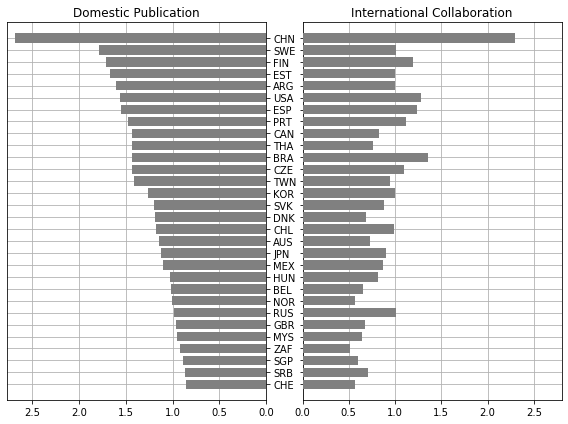

In [17]:
y = np.arange(len(label))

fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(8,6))
axes[0].barh(y, selfvalue, align='center', color='gray', zorder=10)
axes[0].set(title='Domestic Publication')
axes[1].barh(y, colvalue, align='center', color='gray', zorder=10)
axes[1].set_xlim(0,2.8)
axes[1].set(title='International Collaboration')

axes[0].invert_xaxis()
axes[0].set(yticks=y, yticklabels=label)
axes[0].yaxis.tick_right()

for ax in axes.flat:
    ax.margins(0.03)
    ax.grid(True)

fig.tight_layout()
fig.subplots_adjust(wspace=0.14)
plt.show()